In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
import tarfile
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

# Download and extract UrbanSound8K dataset
DATASET_URL = "https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz"
DATASET_PATH = "/content/UrbanSound8K/"
ZIP_PATH = "/content/UrbanSound8K.tar.gz"

if not os.path.exists(DATASET_PATH):
    print("Downloading dataset...")
    response = requests.get(DATASET_URL, stream=True)
    with open(ZIP_PATH, "wb") as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)

    print("Extracting dataset...")
    with tarfile.open(ZIP_PATH, 'r:gz') as tar:
        tar.extractall(path="/content/")

METADATA_PATH = os.path.join(DATASET_PATH, "metadata/UrbanSound8K.csv")
audio_metadata = pd.read_csv(METADATA_PATH)



Extracting dataset...


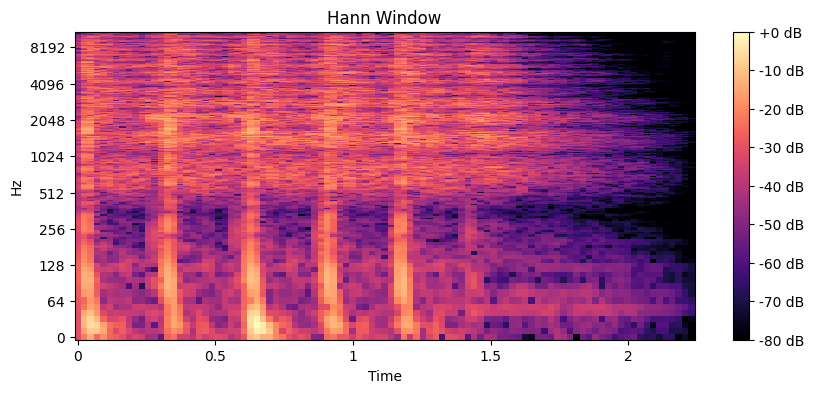

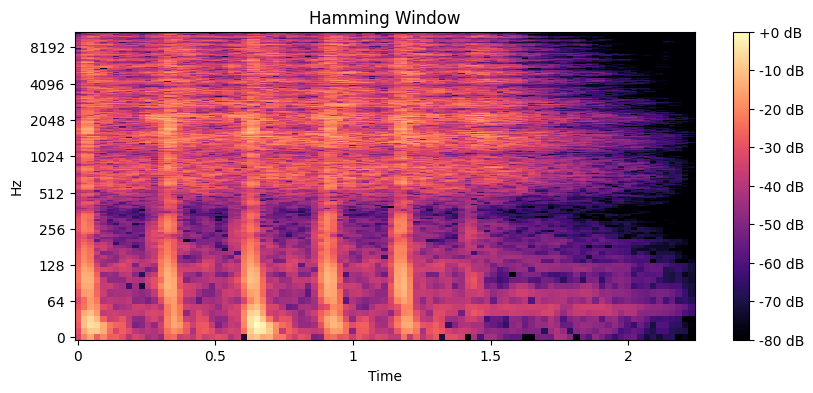

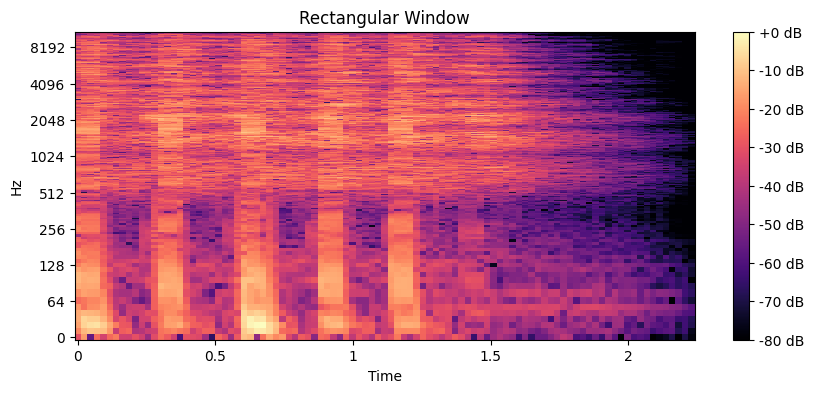

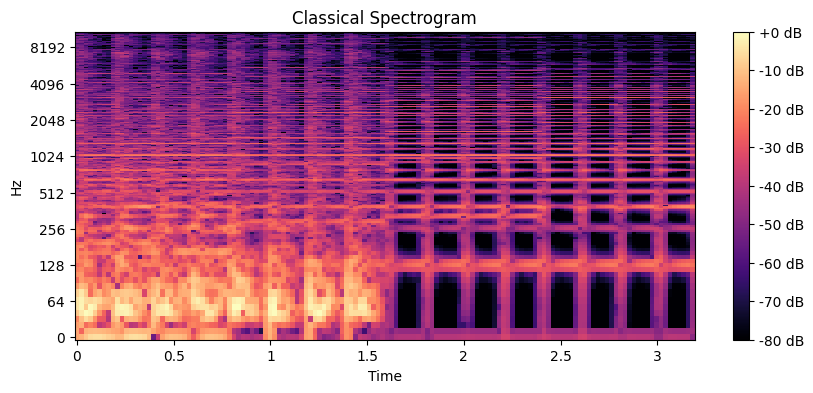

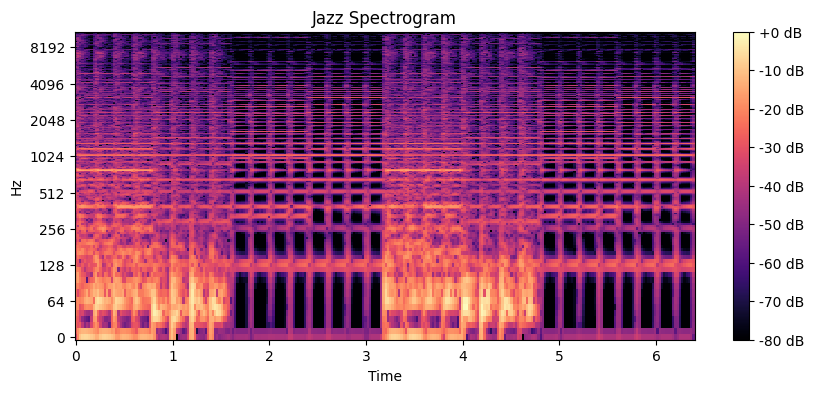

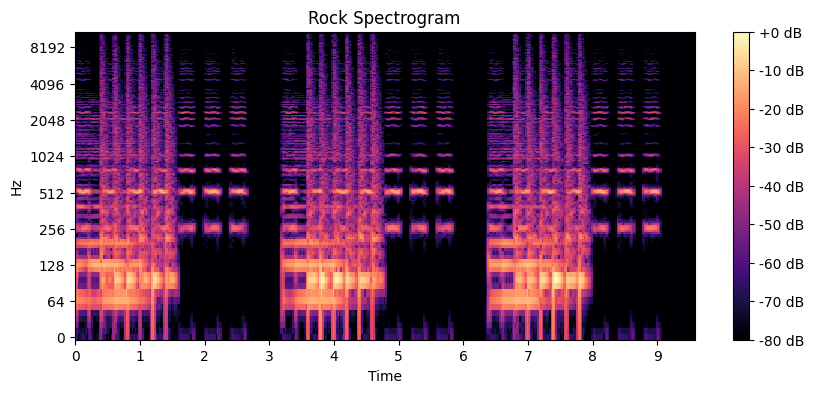

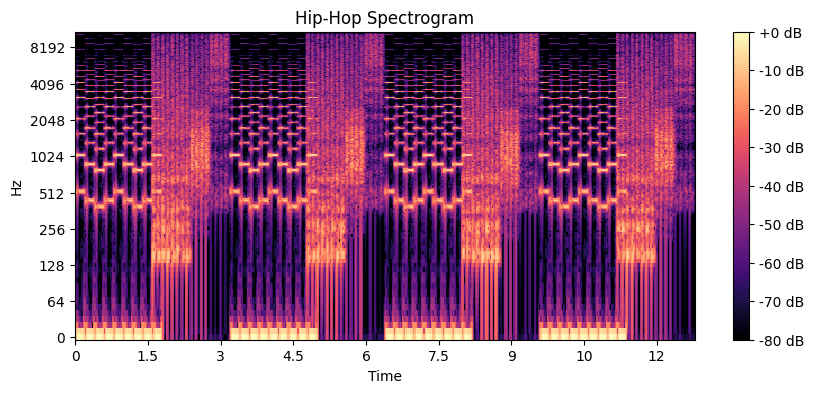

In [ ]:
# Download and extract Task B songs
task_b_songs = {
    "Classical": "https://download.samplelib.com/wav/sample-3s.wav",
    "Jazz": "https://download.samplelib.com/wav/sample-6s.wav",
    "Rock": "https://download.samplelib.com/wav/sample-9s.wav",
    "Hip-Hop": "https://download.samplelib.com/wav/sample-12s.wav"
}

task_b_song_paths = {}
for genre, url in task_b_songs.items():
    song_path = f"/content/{genre}.wav"
    response = requests.get(url, stream=True)
    with open(song_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
    task_b_song_paths[genre] = song_path

# Function to load audio and apply windowing techniques
def load_audio(file_path, sr=22050):
    y, sr = librosa.load(file_path, sr=sr)
    return y, sr

# Define windowing functions
def apply_window(y, window_type, n_fft=2048, hop_length=512):
    if window_type == 'hann':
        # Use scipy.signal.get_window with 'hann' for compatibility
        window = scipy.signal.get_window('hann', n_fft)
    elif window_type == 'hamming':
        window = scipy.signal.get_window('hamming', n_fft) # Use scipy.signal.get_window for hamming as well for consistency
    else:  # rectangular
        window = np.ones(n_fft)

    stft_result = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window)
    return librosa.amplitude_to_db(np.abs(stft_result), ref=np.max)


# Visualize spectrograms
def plot_spectrogram(y, title, sr=22050, n_fft=2048, hop_length=512, window_type='hann'):
    spec = apply_window(y, window_type, n_fft, hop_length)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spec, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

# Example: Load and visualize an audio sample
file_name = os.path.join(DATASET_PATH, "audio/fold1/7061-6-0-0.wav")
y, sr = load_audio(file_name)

plot_spectrogram(y, "Hann Window", window_type='hann')
plot_spectrogram(y, "Hamming Window", window_type='hamming')
plot_spectrogram(y, "Rectangular Window", window_type='rectangular')

# Feature extraction using MFCC
def extract_features(y, sr, n_mfcc=40):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc.T, axis=0)

# Task B: Compare spectrograms of 4 different songs
for genre, song_path in task_b_song_paths.items():
    y, sr = load_audio(song_path)
    plot_spectrogram(y, f"{genre} Spectrogram", window_type='hann')


In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader

# Windowing techniques
WINDOWS = {
    "Hann": scipy.signal.windows.hann(1024),
    "Hamming": scipy.signal.windows.hamming(1024),
    "Rectangular": np.ones(1024)  # Rectangular window
}

# Function to load audio and extract MFCC features after applying windowing
def extract_features(file_path, window_type="Hann", sr=22050, n_mfcc=40):
    y, sr = librosa.load(file_path, sr=sr)

    # Apply STFT with the selected window
    stft_result = librosa.stft(y, n_fft=1024, hop_length=512, window=WINDOWS[window_type])
    magnitude_spectrogram = np.abs(stft_result)

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(magnitude_spectrogram), sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc.T, axis=0)


# Train and evaluate for each windowing technique
for window_type in WINDOWS.keys():
    print(f"\nTraining model using {window_type} Window...")

    # Prepare dataset
    features, labels = [], []
    for index, row in audio_metadata.iterrows():
        file_path = os.path.join(DATASET_PATH, "audio", f"fold{row['fold']}", row['slice_file_name'])
        if os.path.exists(file_path):
            features.append(extract_features(file_path, window_type))
            labels.append(row['class'])

    # Convert to numpy arrays
    features = np.array(features)
    labels = np.array(labels)

    # Encode labels
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define simple neural network classifier
    class AudioClassifier(nn.Module):
        def __init__(self, input_dim, num_classes):
            super(AudioClassifier, self).__init__()
            self.fc1 = nn.Linear(input_dim, 128)
            self.fc2 = nn.Linear(128, 64)
            self.fc3 = nn.Linear(64, num_classes)
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(0.3)

        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    # Convert data to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create DataLoader
    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model setup
    input_dim = X_train.shape[1]
    num_classes = len(np.unique(labels))
    model = AudioClassifier(input_dim, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train model
    def train_model(model, train_loader, criterion, optimizer, epochs=10):
        model.train()
        for epoch in range(epochs):
            total_loss = 0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

    train_model(model, train_loader, criterion, optimizer)

    # Evaluate model
    def evaluate_model(model, test_loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        print(f"{window_type} Window - Test Accuracy: {100 * correct / total:.2f}%")

    evaluate_model(model, test_loader)



Training model using Hann Window...
Epoch 1/10, Loss: 1.7521
Epoch 2/10, Loss: 1.2937
Epoch 3/10, Loss: 1.1503
Epoch 4/10, Loss: 1.0454
Epoch 5/10, Loss: 0.9582
Epoch 6/10, Loss: 0.9073
Epoch 7/10, Loss: 0.8523
Epoch 8/10, Loss: 0.8098
Epoch 9/10, Loss: 0.7615
Epoch 10/10, Loss: 0.7326
Hann Window - Test Accuracy: 78.59%

Training model using Hamming Window...
Epoch 1/10, Loss: 1.7499
Epoch 2/10, Loss: 1.3013
Epoch 3/10, Loss: 1.1420
Epoch 4/10, Loss: 1.0417
Epoch 5/10, Loss: 0.9713
Epoch 6/10, Loss: 0.9123
Epoch 7/10, Loss: 0.8656
Epoch 8/10, Loss: 0.8198
Epoch 9/10, Loss: 0.7653
Epoch 10/10, Loss: 0.7480
Hamming Window - Test Accuracy: 78.48%

Training model using Rectangular Window...
Epoch 1/10, Loss: 1.7332
Epoch 2/10, Loss: 1.3068
Epoch 3/10, Loss: 1.1551
Epoch 4/10, Loss: 1.0562
Epoch 5/10, Loss: 0.9834
Epoch 6/10, Loss: 0.9268
Epoch 7/10, Loss: 0.8706
Epoch 8/10, Loss: 0.8337
Epoch 9/10, Loss: 0.7923
Epoch 10/10, Loss: 0.7632
Rectangular Window - Test Accuracy: 77.85%
